In [1]:
import re
import ast
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns

# --- 1. LOG DATA EXTRACTED FROM USER'S INPUT ---
# The parser is designed to extract only the lines containing 'Epoch XXXX: metrics: {...}'


def parse_logs(log_content):
    """
    Parses the log content to extract epoch and metric values.
    """
    # Regex to capture the Epoch number and the entire Python-like dictionary string
    # It accounts for the variable prefix (e.g., 'generation.trainer - 2025-11-01 17:25:55,281 - ')
    pattern = re.compile(r"Epoch (\d+).*metrics: ({.*?})", re.DOTALL)
    all_metrics_data = {}
    last_epoch = 0
    for line in log_content.strip().split('\n'):
        match = pattern.search(line)
        if match:
            try:
                epoch = int(match.group(1))
                metrics_str = match.group(2)
                metrics = ast.literal_eval(metrics_str)
                if epoch > last_epoch:
                    for metric_name, value in metrics.items():
                        if metric_name not in all_metrics_data:
                            all_metrics_data[metric_name] = []
                        all_metrics_data[metric_name].append((epoch, value))
                        last_epoch = epoch
            except (ValueError, SyntaxError, IndexError) as e:
                # This error handling is crucial for truncated or malformed lines
                print(f"Skipping line due to parsing error: {e} in line: {line[:100]}...")
                continue
    
    return all_metrics_data

def plot_metrics(metrics_data):
    """
    Plots metrics on a single X-axis using two separate Y-axes (twinx) 
    to handle metrics with different scales (e.g., loss vs F1 scores).
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # 1. Setup the figure and primary axis (for large-scale metrics like 'loss')
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Create the secondary axis (for small-scale metrics like F1 scores)
    ax2 = ax1.twinx()
    
    # Define metric groups based on name heuristic: 'loss' is typically large-scale
    PRIMARY_METRICS = ['Cardinality on small_group gen']
    EXCLUDE_METRICS = ['loss','---GenOTD userwise_denom','---Matched R1 amount_rur userwise_denom','---Matched trans_date userwise_denom']
    
    primary_metrics_data = {k: v for k, v in metrics_data.items() if k in PRIMARY_METRICS and k not in EXCLUDE_METRICS}
    secondary_metrics_data = {k: v for k, v in metrics_data.items() if k not in PRIMARY_METRICS and k not in EXCLUDE_METRICS}
    
    # Define colors for clarity (using standard Matplotlib cycle)
    # primary_color = 'tab:blue'
    # secondary_colors = ['tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    category_colors = sns.color_palette("Set1", 10)

    primary_color = category_colors[0]
    secondary_colors = {"GenOTD":category_colors[1],"GenOTD micro":category_colors[1],
                       "Matched R1 amount_rur":category_colors[2],"Paired R1 amount_rur":category_colors[2],
                       "Matched trans_date":category_colors[3],"Paired trans_date":category_colors[3],
                       "Matched F1 small_group":category_colors[4],"Paired F1 small_group":category_colors[4],
                        "Matched F1 small_group micro":category_colors[5],"Paired F1 small_group micro":category_colors[5]
                       }
    MAX_MARKER_SIZE = 150
    all_handles = []
    
    # --- 2. Plot Primary Metrics (Left Y-Axis) ---
    ax1.set_ylabel('Cardinality', color=primary_color, fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=primary_color)
    ax1.grid(False) # Turn off primary grid so secondary grid can be dominant
    
    for metric_name, data in primary_metrics_data.items():
        epochs = [item[0] for item in data]
        values = [item[1] for item in data]
        
        # Plot line
        line, = ax1.plot(epochs, values,  linewidth=2, color=primary_color, label=metric_name)
        all_handles.append(line)
        
        # Highlight Max Value
        # Note: Since loss is often negative, max() might find the value closest to zero, 
        # which is the "best" loss in a negative-valued context.
        max_value = max(values) 
        max_index = values.index(max_value)
        max_epoch = epochs[max_index]
        
        ax1.scatter(max_epoch, max_value, color=primary_color, s=MAX_MARKER_SIZE, zorder=5, edgecolor='black', alpha=0.8)
        
        ax1.annotate(f'{max_value:.3f}', (max_epoch, max_value), textcoords="offset points", xytext=(10, -15),
                    ha='center', color="black", fontsize=9, 
                    arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.2", color="black"))


    # --- 3. Plot Secondary Metrics (Right Y-Axis) ---
    # Construct the label dynamically to list all secondary metrics
    secondary_label = ', '.join(secondary_metrics_data.keys())
    #ax2.set_ylabel(f'Performance Scores ({secondary_label})', color=secondary_colors[0], fontsize=12, fontweight='bold')
    #ax2.tick_params(axis='y', labelcolor=secondary_colors[0])
    ax2.grid(True, linestyle='--', alpha=0.7) # Keep grid on the secondary axis for score readability

    for metric_name, data in secondary_metrics_data.items():
        #color = secondary_colors[color_idx % len(secondary_colors)]
        color = secondary_colors[metric_name]
        
        epochs = [item[0] for item in data]
        values = [item[1] for item in data]
        
        # Plot line on the secondary axis
        line, = ax2.plot(epochs, values,  linewidth=2, color=color, label=metric_name)
        all_handles.append(line)
        
        # Highlight Max Value
        max_value = max(values)
        max_index = values.index(max_value)
        max_epoch = epochs[max_index]
        
        ax2.scatter(max_epoch, max_value, color=color, s=MAX_MARKER_SIZE, zorder=5, edgecolor='black', alpha=0.8)

        ax2.annotate(f'{max_value:.3f}', (max_epoch, max_value), textcoords="offset points", xytext=(10, 5),
                    ha='center', color="black", fontsize=9, 
                    arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=-0.2", color="black"))

    # --- 4. Final Customization ---
    ax1.set_title('Training Metrics Over Epochs (Dual Y-Axes)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    
    # Set x-ticks to only show integer epochs
    if epochs:
        ax1.set_xticks(epochs)
    
    # Combined legend for all lines
    ax1.legend(handles=all_handles, loc='upper center', bbox_to_anchor=(0.5, -0.1), title='Metrics', fontsize='small',ncol=5)
    
    plt.tight_layout()
    plt.show()

# if __name__ == "__main__":
#     # --- Run the parser and plotter using the defined LOG_DATA (for simulation) ---
#     file_path = sys.argv[1]  # <-- EDIT THIS TO YOUR LOG FILE NAME
#     log_content = ""

#     try:
#         # Read the entire file content into a single string
#         with open(file_path, 'r') as f:
#             log_content = f.read()
#         print(f"Successfully loaded data from: {file_path}")
#     except FileNotFoundError:
#         # If the file is not found, exit the script immediately.
#         print(f"Error: Log file not found at '{file_path}'. Exiting process.")
#         sys.exit(1) # <-- Script exits here
        
#     parsed_data = parse_logs(log_content)
    
#     if parsed_data:
#         plot_metrics(parsed_data)
#     else:
#         print("No valid metric data found in the logs.")

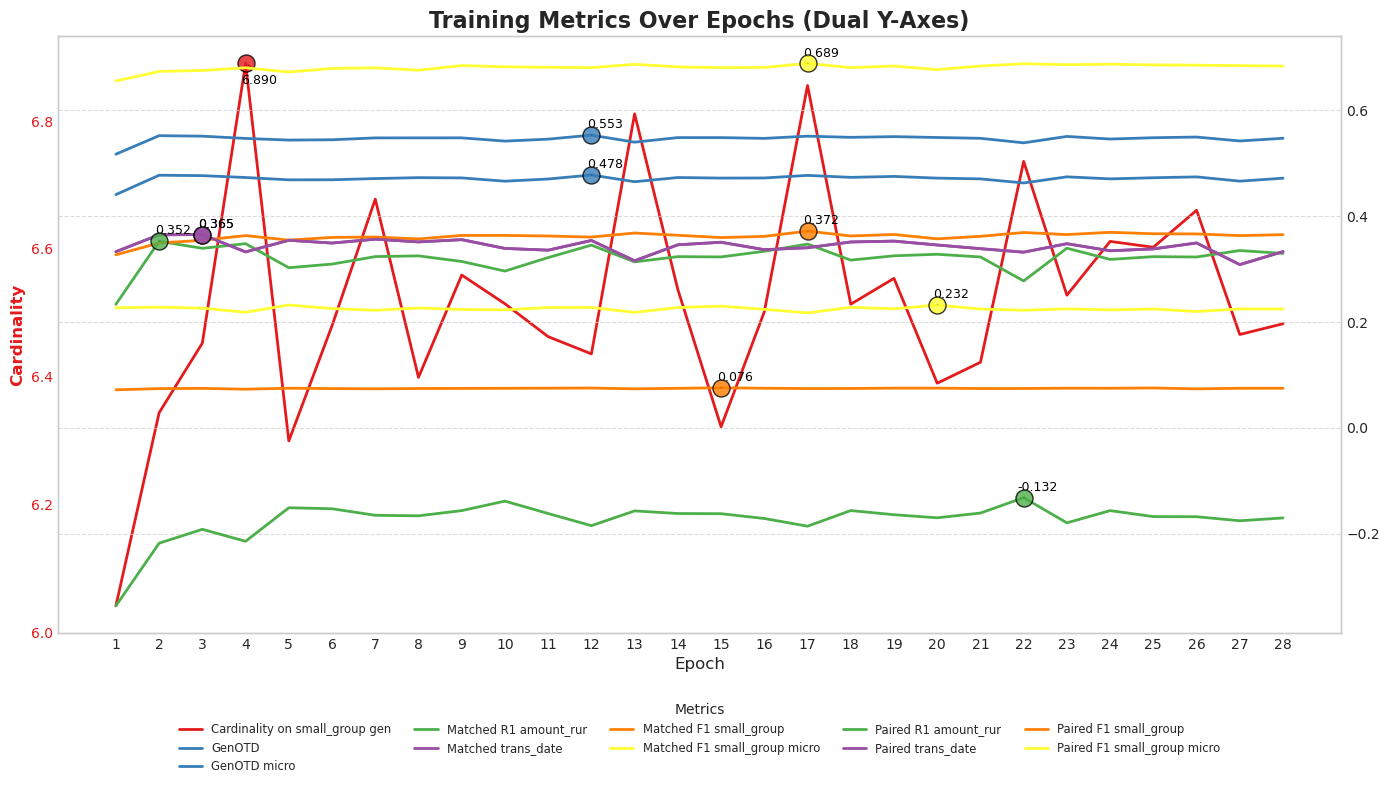

In [2]:
## this log is for run with deltas in loss and generation,
## pure detpp
file_path = "log/generation/age/detpp/seed_0/log"
with open(file_path, 'r') as f:
    log_content = f.read()
parsed_data = parse_logs(log_content)

if parsed_data:
    plot_metrics(parsed_data)

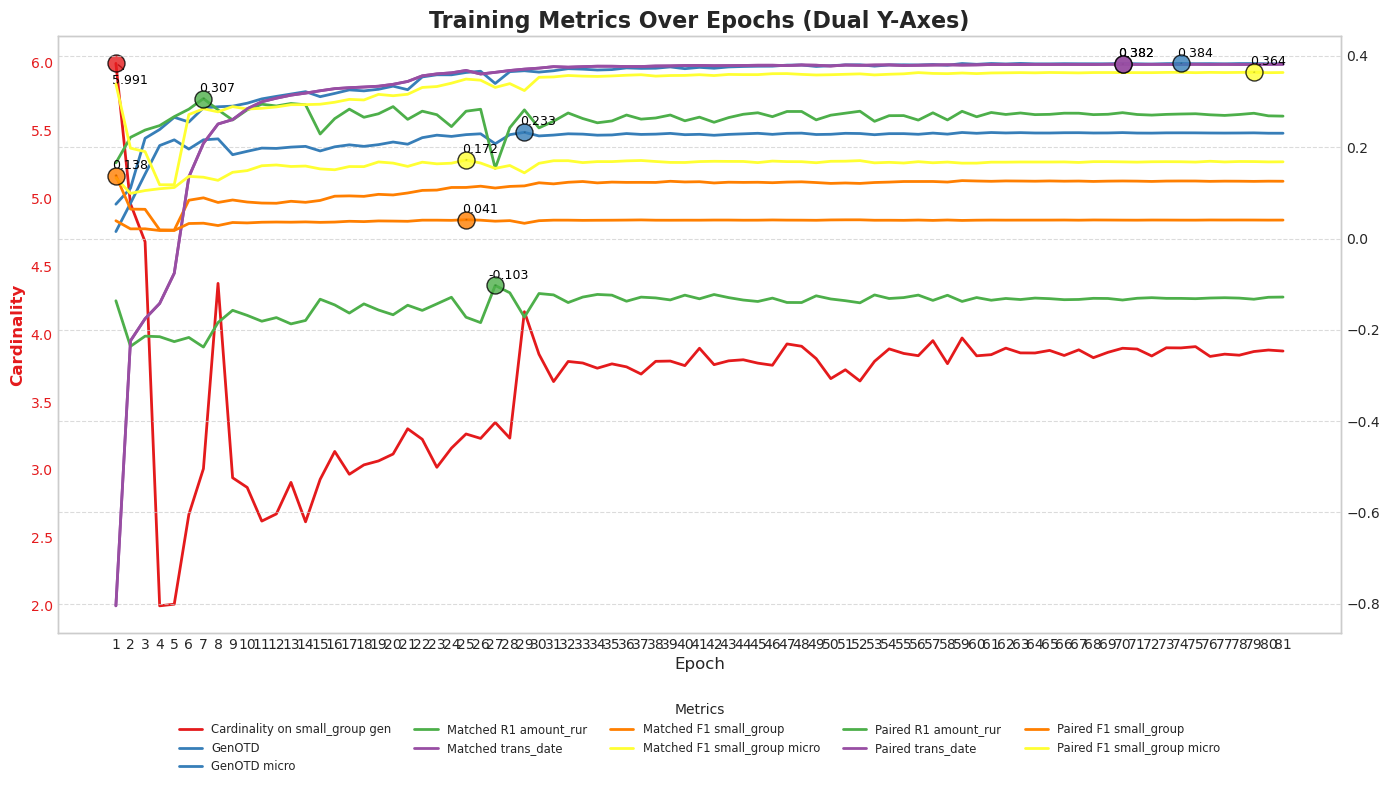

In [10]:
## this log is for run with deltas in loss and generation,
## with different scale in VAE and data_conf
file_path = "log/generation/age/detpp_vae/seed_0/log"
with open(file_path, 'r') as f:
    log_content = f.read()
parsed_data = parse_logs(log_content)

if parsed_data:
    plot_metrics(parsed_data)

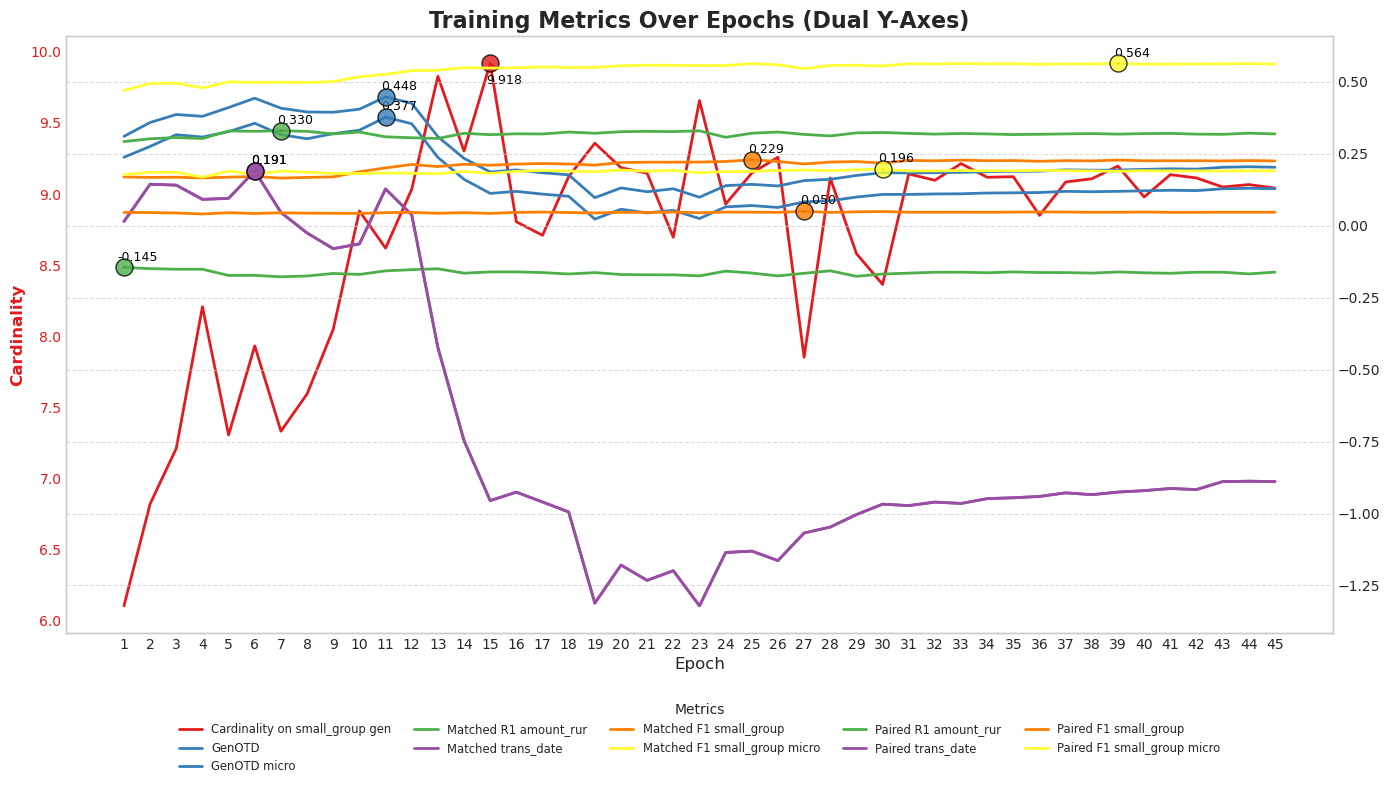

In [11]:
## this log is for run with deltas in loss and generation,
## without time.clip in generation
## with unique scale in VAE and data_conf
file_path = "log/generation/age/detpp_vae(6)/seed_0/log"
with open(file_path, 'r') as f:
    log_content = f.read()
parsed_data = parse_logs(log_content)

if parsed_data:
    plot_metrics(parsed_data)

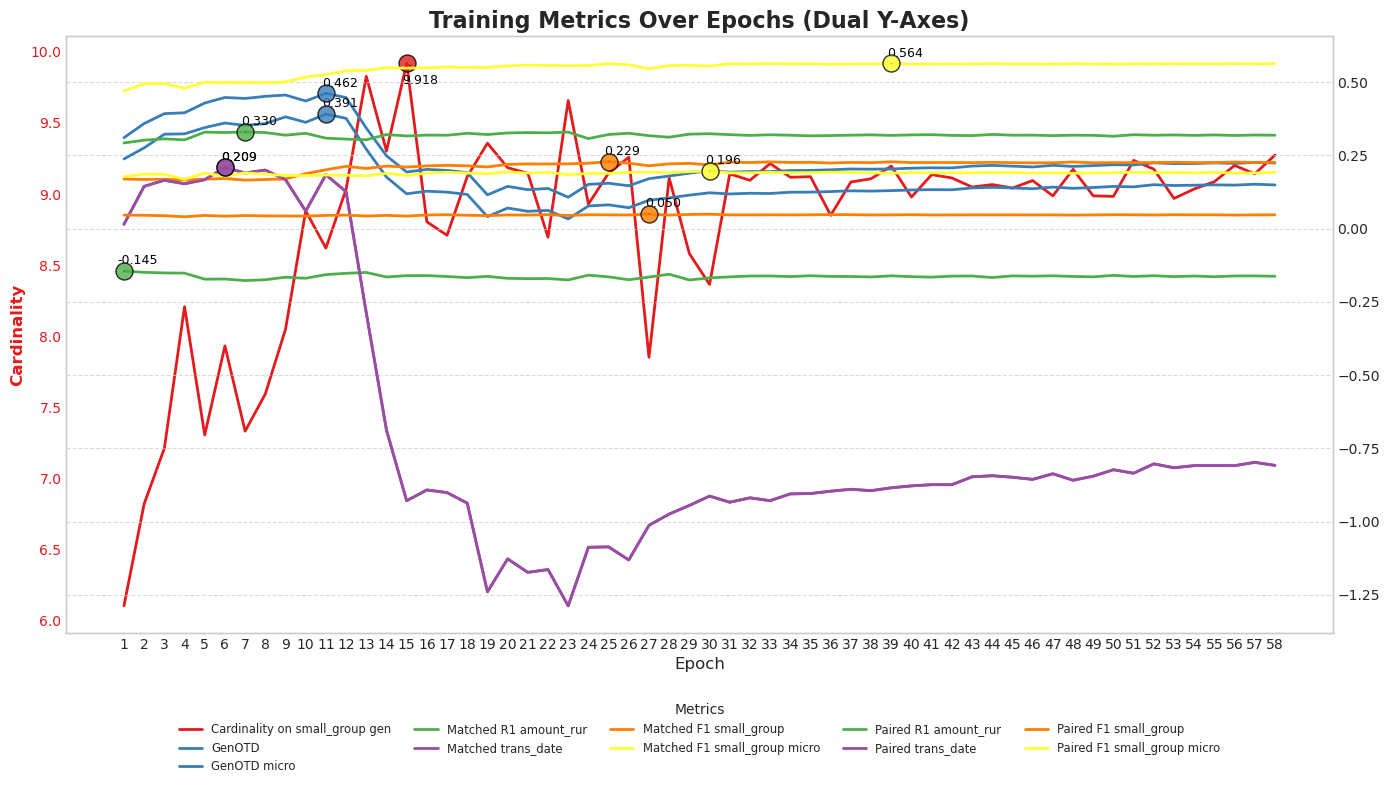

In [13]:
## this log is for run with deltas in loss and generation,
## with unique scale in VAE and data_conf, 730
file_path = "log/generation/age/detpp_vae(5)/seed_0/log"
with open(file_path, 'r') as f:
    log_content = f.read()
parsed_data = parse_logs(log_content)

if parsed_data:
    plot_metrics(parsed_data)

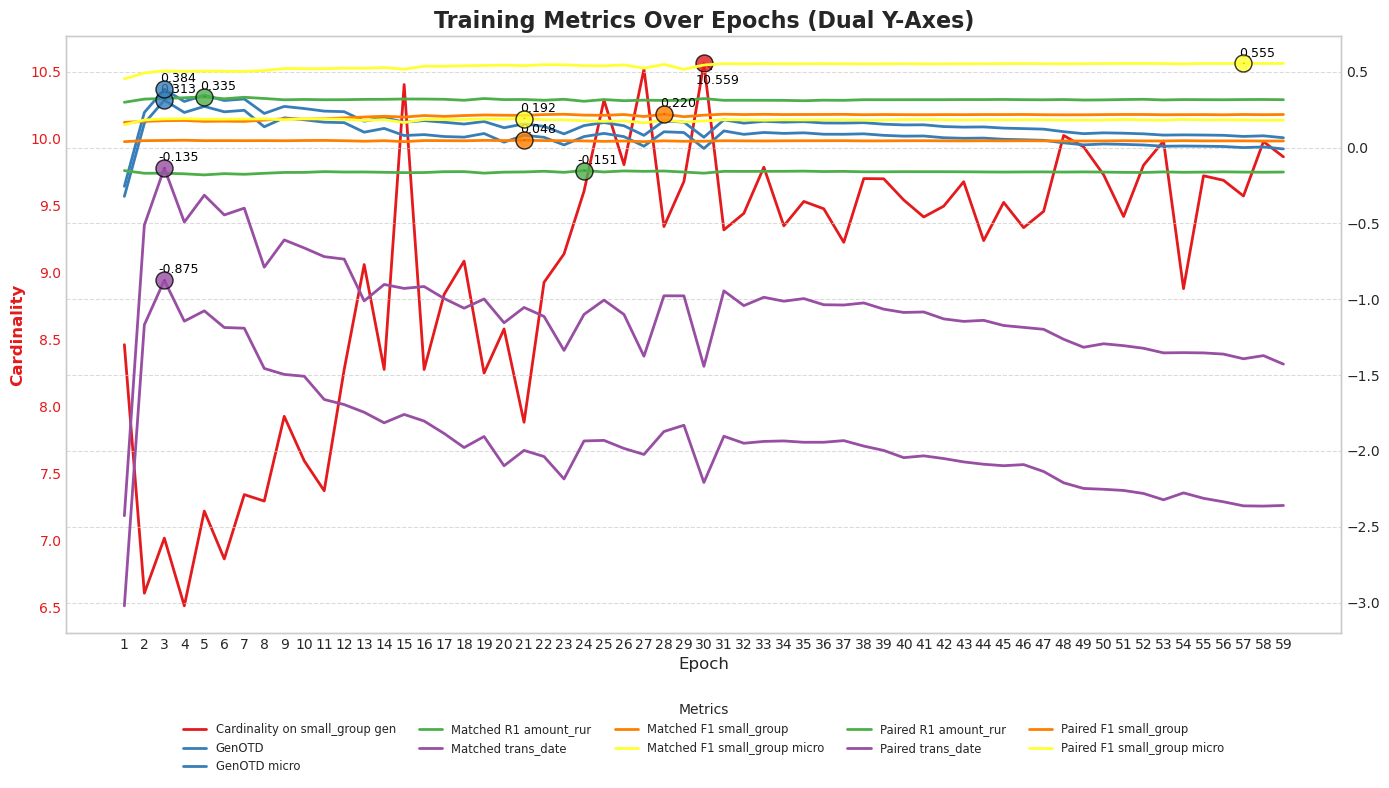

In [6]:
## this log is for run without deltas in loss and generation,
## with unique scale in VAE and data_conf

file_path = "log/generation/age/detpp_vae(4)/seed_0/log"
with open(file_path, 'r') as f:
    log_content = f.read()
parsed_data = parse_logs(log_content)

if parsed_data:
    plot_metrics(parsed_data)

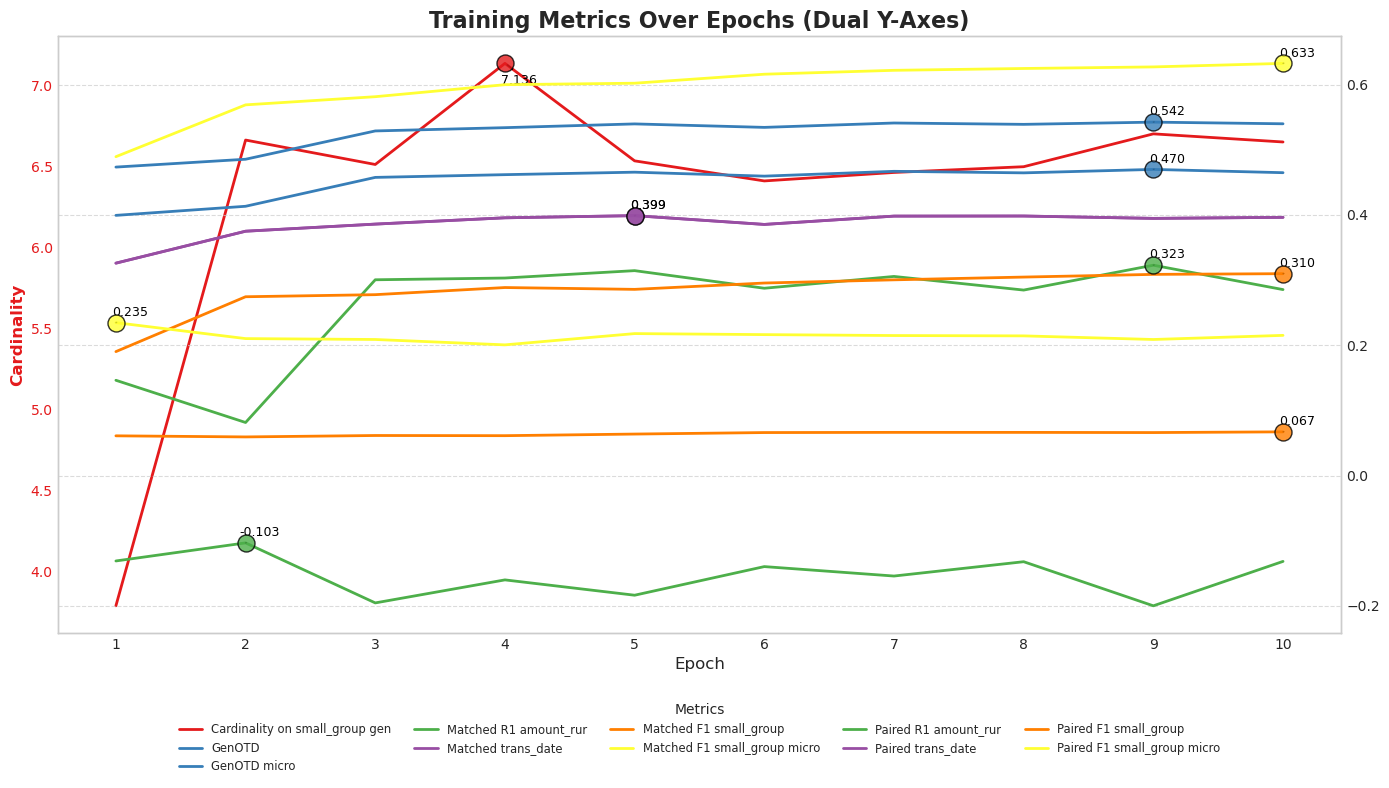

In [21]:
## this log is for run with deltas in loss and generation,
## without time.clip
## with unique scale in VAE and data_conf, 1
## train VAE from scratch
file_path = "log/generation/age/detpp_vae(9)/seed_0/log"
with open(file_path, 'r') as f:
    log_content = f.read()
parsed_data = parse_logs(log_content)

if parsed_data:
    plot_metrics(parsed_data)